# Distance-based treatment effects

Based on the figures from Holodinsky et al. 2017 - "Drip and Ship Versus Direct to Comprehensive Stroke Center"

## Notebook admin

In [1]:
# Import packages
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
from matplotlib.path    import Path
from matplotlib.patches import PathPatch

In [3]:
# Set up MatPlotLib
%matplotlib inline
# Change default colour scheme:
plt.style.use('seaborn-colorblind')

### Assumptions 

In [4]:
fixed_times = dict(
    onset_to_ambulance_arrival = 60,
    ivt_arrival_to_treatment   = 30,
    transfer_additional_delay  = 60,
    travel_ivt_to_mt           = 60,
    mt_arrival_to_treatment    = 90,
    )

---

# Define time grids.

For each point on a grid, find the travel time to a given coordinate (one of the treatment centres).

The treatment centres are located at the following coordinates:

+ IVT centre: (0, 0)
+ IVT/MT centre: (0, $-t_{\mathrm{travel}}^{\mathrm{IVT~to~MT}}$)

Change these parameters:

In [5]:
# Only calculate travel times up to this x and y displacement:
time_travel_max       = 240

# Change how granular the grid is. 
grid_step = 5 # minutes

# Make the grid a bit larger than the max travel time: 
grid_xy_max = time_travel_max + grid_step*2

Define a helper function to build the time grid:

In [6]:
def make_time_grid(xy_max, step, x_offset=0, y_offset=0):
    # Times for each row....
    x_times = np.arange(-xy_max, xy_max + step, step) - x_offset
    # ... and each column.
    y_times = np.copy(x_times) - y_offset
    # The offsets shift the position of (0,0) from the grid centre 
    # to (x_offset, y_offset). Distances will be calculated from the
    # latter point. 

    # Mesh to create new grids by stacking the rows (xx) 
    # and columns (yy):
    xx, yy = np.meshgrid(x_times, y_times)

    # Then combine the two temporary grids to find distances: 
    radial_times = np.sqrt(xx**2.0 + yy**2.0)
    return radial_times

Travel time directly to the IVT centre:

In [7]:
grid_time_travel_directly_to_ivt = make_time_grid(grid_xy_max, grid_step)

Travel time directly to the MT centre:

In [8]:
grid_time_travel_directly_to_mt = (
    make_time_grid(grid_xy_max, grid_step, 
                   y_offset=-fixed_times['travel_ivt_to_mt']) )

Difference in travel time:

In [9]:
grid_time_travel_directly_diff = (
    grid_time_travel_directly_to_ivt - grid_time_travel_directly_to_mt)

## Plot the grids

In [10]:
extent = [-grid_xy_max - grid_step*0.5, 
          +grid_xy_max - grid_step*0.5, 
          -grid_xy_max - grid_step*0.5, 
          +grid_xy_max - grid_step*0.5] 

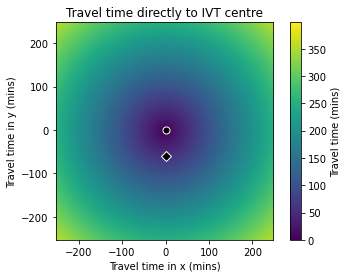

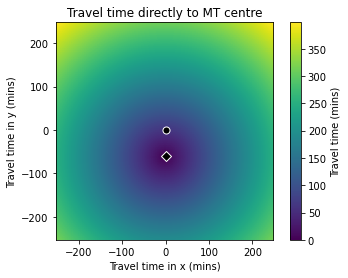

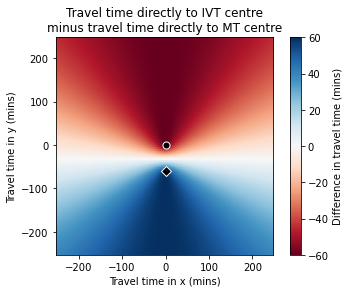

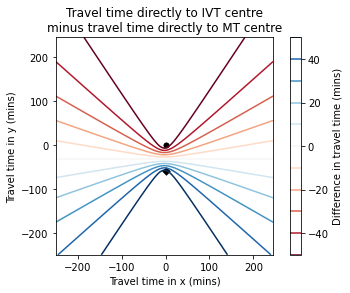

In [11]:
vmin = 0
vmax = np.max([grid_time_travel_directly_to_ivt,
               grid_time_travel_directly_to_mt])

for i in range(4):
    if i==0:
        # Travel directly to IVT centre
        plt.imshow(grid_time_travel_directly_to_ivt, origin='lower', 
                   extent=extent, vmin=vmin, vmax=vmax)
        plt.colorbar(label='Travel time (mins)')
        plt.title('Travel time directly to IVT centre')
        
    elif i==1:
        # Travel directly to IVT/MT centre
        plt.imshow(grid_time_travel_directly_to_mt, origin='lower', 
                   extent=extent, vmin=vmin, vmax=vmax)
        plt.colorbar(label='Travel time (mins)')
        plt.title('Travel time directly to MT centre')
        
    elif i==2:
        # Difference grid 
        plt.imshow(grid_time_travel_directly_diff, origin='lower', 
                   extent=extent, cmap='RdBu')
        plt.colorbar(label='Difference in travel time (mins)')
        plt.title('Travel time directly to IVT centre'+'\n'+
                  'minus travel time directly to MT centre')
        
    elif i==3:
        # Difference contours
        plt.contour(grid_time_travel_directly_diff, origin='lower', 
                    extent=extent,
                    levels=np.arange(-50,60,10), cmap='RdBu')
        plt.colorbar(label='Difference in travel time (mins)')
        plt.title('Travel time directly to IVT centre'+'\n'+
                  'minus travel time directly to MT centre')
                
    # Mark the treatment centre locations:
    plt.scatter(0,0, marker='o', color='k', edgecolor='w', s=50)
    plt.scatter(0,-fixed_times['travel_ivt_to_mt'], marker='D', 
                color='k', edgecolor='w', s=50)

    plt.xlabel('Travel time in x (mins)')
    plt.ylabel('Travel time in y (mins)')
    
    plt.gca().set_aspect('equal')
    plt.show()

There is a horizontal line halfway between the two treatment centres that marks where the travel times to the two treatment centres are equal. 

__Presumably these curves match the ones drawn in the Holodinsky et al. 2017 paper.__

---

# Travel time plot

Update plotting style:

In [12]:
time_step_circle = 15
circ_linewidth   = 0.5
grid_cmap        = 'viridis' 

Helper function to draw radiating circles from the IVT centre:

In [13]:
def make_coords_truncated_circle(time_travel_max, time_travel_ivt_to_mt, 
                                 trunc_val=None, n_coords=360):
    # Find the point halfway between the treatment centres:
    y_halfway = -0.5*fixed_times['travel_ivt_to_mt']
    if trunc_val == None:
        trunc_val = y_halfway
    
    # Make a normal circle...
    angles_circle = np.linspace(0,2.0*np.pi,n_coords)
    x_circ = time_travel_max * np.sin(angles_circle)
    y_circ = time_travel_max * np.cos(angles_circle)
    # ... then cut it off at the halfway point between the treatment 
    # centres:
    y_circ[np.where(y_circ < y_halfway)] = trunc_val 

    return x_circ, y_circ

Helper function to find colour limits within the largest flattened radiating circle:

In [42]:
def find_vlims_within_flattened_circle(grid_diff, grid_ivt, time_travel_max):
    """
    # Determine the min and max times in the area of the largest flattened
    # circle. 
    """
    # Make a copy of the grid that we'll delete invalid values from:
    grid_vals_uncovered = np.copy(grid_diff)
    
    # Find values below the flat circle bottom:
    y_grid_halfway = np.where(grid_diff == np.nanmin(np.abs(grid_diff)))[0][0]
    
    # Find values outside the radius of the largest circle:
    coords_outside_max_time = np.where(grid_ivt > time_travel_max)
    
    # Remove unwanted values:
    grid_vals_uncovered[:y_grid_halfway]         = np.NaN
    grid_vals_uncovered[coords_outside_max_time] = np.NaN
    
    # Find the min and max values in this partially wiped grid: 
    vmin = np.nanmin(grid_vals_uncovered)
    vmax = np.nanmax(grid_vals_uncovered)
    return vmin, vmax

The main plot: 

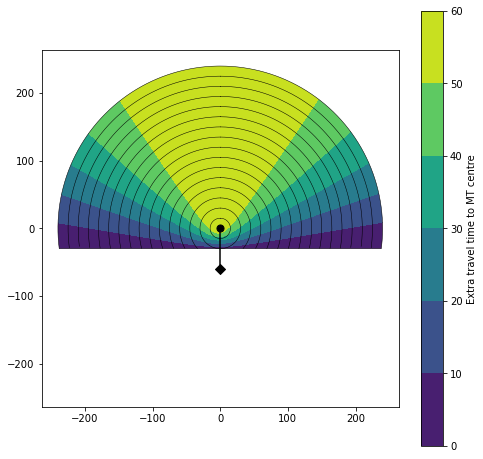

In [46]:
fig, ax = plt.subplots(figsize=(8,8))

# ----- Treatment centres ----- 
# Mark the treatment centre locations:
ax.scatter(0,0, marker='o', color='k', s=50, zorder=5)
ax.scatter(0,-fixed_times['travel_ivt_to_mt'], marker='D', color='k', s=50)
# And draw a connecting line:
ax.plot([0,0], [0,-fixed_times['travel_ivt_to_mt']], color='k')


# ----- Radiating circles ----- 
# Define times for the radiating circles:
circle_times = np.arange(
    time_step_circle, time_travel_max + time_step_circle, time_step_circle)

# Define coordinates and plot the radiating circles:
for travel_time in circle_times:
    if travel_time<time_travel_max:
        # Don't show the flat bottom line (gets thickened) 
        trunc_val = np.NaN
    else:
        # Show the flat bottom line 
        trunc_val = None
    # Define coordinates of the travel time circle.
    x_circ, y_circ = make_coords_truncated_circle(
        travel_time, fixed_times['travel_ivt_to_mt'], trunc_val=trunc_val)

    if travel_time<time_travel_max:
        ax.plot(x_circ, y_circ, color='k', linewidth=circ_linewidth)
    else:
        # Make a patch using these coordinates. 
        # Use np.stack to get a series of ((x,y), (x,y), ... (x,y)) coords.
        circle_path  = Path(np.stack((x_circ,y_circ),axis=1))
        circle_patch = PathPatch(circle_path, 
                                 edgecolor='k', facecolor='None',
                                 linewidth = circ_linewidth)
        # Draw the patch:
        ax.add_patch(circle_patch)


# ----- Grid of times ----- 
vmin, vmax = find_vlims_within_flattened_circle(
    -grid_time_travel_directly_diff, 
    grid_time_travel_directly_to_ivt, 
    time_travel_max)

imshow = 0
if imshow>0:
    # Draw the grid as usual:
    imshow_grid = ax.imshow(-grid_time_travel_directly_diff, origin='lower', 
                            extent=extent, cmap='viridis',
                            vmin=vmin, vmax=vmax
                           )
    # Remove everything outside the biggest radiating circle:
    imshow_grid.set_clip_path(circle_patch)
    # Colourbar:
    plt.colorbar(imshow_grid, ax=ax, label='Extra travel time to MT centre')
else:
    # Draw the grid as usual:
    contours = ax.contourf(-grid_time_travel_directly_diff, origin='lower', 
                           extent=extent, cmap='viridis', 
                           levels=np.linspace(vmin, vmax,7))
    # Remove everything outside the biggest radiating circle:
    for line in contours.collections:
        line.set_clip_path(circle_patch)
    # Colourbar:
    plt.colorbar(contours, ax=ax, label='Extra travel time to MT centre')

# ----- Other setup -----
ax.set_aspect('equal')
ax.set_xlim(-time_travel_max*1.1, time_travel_max*1.1)
ax.set_ylim(-time_travel_max*1.1, time_travel_max*1.1)
plt.show()


# Convert time grid to mRS grid

In [48]:
from outcome_utilities.clinical_outcome import Clinical_outcome

In [49]:
import pandas as pd

In [50]:
mrs_dists = pd.read_csv(
    './outcome_utilities/mrs_dist_probs_cumsum.csv', index_col='Stroke type')

In [51]:
# Set up outcome model
outcome_model = Clinical_outcome(mrs_dists, patients=100)

/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:109: RuntimeWarning: divide by zero encountered in true_divide
  o = p / (1 - p)


In [53]:
# Get outputs
time_to_ivt = 90
time_to_mt = 120
outcomes = outcome_model.calculate_outcomes(time_to_ivt, time_to_mt)

In [54]:
outcomes

{'lvo_untreated_probs': array([0.06, 0.07, 0.15, 0.17, 0.27, 0.2 , 0.08]),
 'nlvo_untreated_probs': array([0.23, 0.28, 0.11, 0.08, 0.11, 0.05, 0.14]),
 'lvo_ivt_probs': array([0.09, 0.12, 0.12, 0.15, 0.28, 0.12, 0.12]),
 'lvo_mt_probs': array([0.18, 0.18, 0.15, 0.15, 0.13, 0.09, 0.12]),
 'nlvo_ivt_probs': array([0.38, 0.26, 0.06, 0.06, 0.1 , 0.03, 0.11]),
 'lvo_untreated_mean_utility': 0.34030000000000005,
 'nlvo_untreated_mean_utility': 0.6074000000000002,
 'lvo_ivt_mean_utility': 0.3974,
 'lvo_mt_mean_utility': 0.5354,
 'nlvo_ivt_mean_utility': 0.6890999999999999,
 'lvo_ivt_added_utility': 0.05709999999999993,
 'lvo_mt_added_utility': 0.19509999999999994,
 'nlvo_ivt_added_utility': 0.08169999999999977,
 'lvo_untreated_cum_probs': array([0.06, 0.13, 0.28, 0.45, 0.72, 0.92, 1.  ]),
 'nlvo_untreated_cum_probs': array([0.23, 0.51, 0.62, 0.7 , 0.81, 0.86, 1.  ]),
 'lvo_ivt_cum_probs': array([0.09, 0.21, 0.33, 0.48, 0.76, 0.88, 1.  ]),
 'lvo_mt_cum_probs': array([0.18, 0.36, 0.51, 0.66, 0.

In [52]:
outcome_model.calculate_outcomes(30, 60)

/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:272: RuntimeWarning: invalid value encountered in true_divide
  treated_probs = treated_odds / (1 + treated_odds)
/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:313: RuntimeWarning: invalid value encountered in true_divide
  treated_probs = treated_odds / (1 + treated_odds)
/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:354: RuntimeWarning: invalid value encountered in true_divide
  treated_probs = treated_odds / (1 + treated_odds)


{'lvo_untreated_probs': array([0.03, 0.11, 0.17, 0.11, 0.22, 0.15, 0.21]),
 'nlvo_untreated_probs': array([0.21, 0.22, 0.13, 0.12, 0.15, 0.05, 0.12]),
 'lvo_ivt_probs': array([0.11, 0.11, 0.12, 0.12, 0.19, 0.13, 0.22]),
 'lvo_mt_probs': array([0.23, 0.14, 0.09, 0.15, 0.29, 0.02, 0.08]),
 'nlvo_ivt_probs': array([0.41, 0.21, 0.1 , 0.1 , 0.08, 0.03, 0.07]),
 'lvo_untreated_mean_utility': 0.3277,
 'nlvo_untreated_mean_utility': 0.5800000000000001,
 'lvo_ivt_mean_utility': 0.3716,
 'lvo_mt_mean_utility': 0.5496,
 'nlvo_ivt_mean_utility': 0.7217999999999999,
 'lvo_ivt_added_utility': 0.043899999999999995,
 'lvo_mt_added_utility': 0.2219,
 'nlvo_ivt_added_utility': 0.14179999999999982,
 'lvo_untreated_cum_probs': array([0.03, 0.14, 0.31, 0.42, 0.64, 0.79, 1.  ]),
 'nlvo_untreated_cum_probs': array([0.21, 0.43, 0.56, 0.68, 0.83, 0.88, 1.  ]),
 'lvo_ivt_cum_probs': array([0.11, 0.22, 0.34, 0.46, 0.65, 0.78, 1.  ]),
 'lvo_mt_cum_probs': array([0.23, 0.37, 0.46, 0.61, 0.9 , 0.92, 1.  ]),
 'nlvo_

---

old

# Convert time grid to mRS grid

Use the probability distributions for LVO and MT. Copied from datasets_full:

In [ ]:
mrs_prob_bins_t0_treatment = np.array([0.3141, 0.4363, 0.5544, 0.7123, 0.8536, 0.9167, 1.    ])
mrs_prob_bins_no_treatment = np.array([0.0478, 0.1233, 0.2532, 0.41  , 0.646 , 0.775 , 1.    ])
t_ne = 8*60 # minutes

### From the maths notebook:

$$ P = \frac{1}{1+e^{-b\left(t +\frac{A}{b}\right)}} $$

$$ A =  \log\bigl[O(\mathrm{mRS}\leq x\ |\ t=0)\bigr] $$

So **$A$ is equal to the log-odds at $t=0\,$hr**.

$$ b = -\frac{a}{t_{\mathrm{ne}}} $$

$$ \log(OR) = a + bt $$

**$a$ is log(odds ratio) at t=0**, and **$b$ is the gradient of the slope**. 

### From the predict notebook:

In [ ]:
from outcome_utilities.probs_with_time import find_mrs_constants

In [ ]:
a, b, A = find_mrs_constants(mrs_prob_bins_t0_treatment, 
                             mrs_prob_bins_no_treatment, t_ne)

In [ ]:
print(a)
print(b)
print(A)

## Example patient

Make some more assumptions about our patient:

In [ ]:
# Equivalent to patient 'x':
prob_start = 0.345

In [ ]:
grids_probs = []

for mrs in range(6):
    grid_probs = 1.0 / (1.0 + np.exp(-b[mrs]*(grid_time_patient1  + A[mrs]/b[mrs])))
    grids_probs.append(grid_probs)
    
    plt.imshow(grid_probs, origin='lower')#, vmin=0, vmax=1)
    plt.colorbar()
    plt.title(f'mRS {mrs}')
    plt.close()

In [ ]:
grid_mrs_patient1 = np.zeros_like(grids_probs[0])

for i,grid in enumerate(grids_probs[1:]):
    good_vals = np.where(grid<prob_start)
    grid_mrs_patient1[good_vals] +=1 #= 6-i

Same but for patient 1a:

In [ ]:
grids_probs = []

for mrs in range(6):
    grid_probs = 1.0 / (1.0 + np.exp(-b[mrs]*(grid_time_patient1a  + A[mrs]/b[mrs])))
    grids_probs.append(grid_probs)

In [ ]:
grid_mrs_patient1a = np.zeros_like(grids_probs[0])

for i,grid in enumerate(grids_probs[1:]):
    good_vals = np.where(grid<prob_start)
    grid_mrs_patient1a[good_vals] +=1 

Plot:

In [ ]:
cmap = plt.get_cmap('viridis', 7)
for grid in [grid_mrs_patient1, grid_mrs_patient1a]:
    plt.imshow(grid, origin='lower', extent=extent,
               vmin=-0.5, vmax=6.5, cmap=cmap)
    plt.colorbar(label='mRS at treatment time')
    plt.show()

In [ ]:
# cmap = plt.get_cmap('viridis', 7)
grid_mrs_diff = grid_mrs_patient1 - grid_mrs_patient1a
plt.imshow(grid_mrs_diff, origin='lower', extent=extent,
           # vmin=-0.5, vmax=6.5, 
           # cmap=cmap)
          )
plt.colorbar(label='Difference in mRS at treatment time')
plt.show()

Need fractional mRS for this to not be minging. 

In [ ]:
from outcome_utilities.clinical_outcome import Clinical_outcome

In [ ]:
import pandas as pd

In [ ]:
mrs_dists = pd.read_csv(
    './outcome_utilities/mrs_dist_probs_cumsum.csv', index_col='Stroke type')

In [ ]:
# Set up outcome model
outcome_model = Clinical_outcome(mrs_dists, patients=100)

In [ ]:
outcome_model.calculate_outcomes(30, 60)